### Лабораторная работа №1
#### Выполнила Блистунова Валерия
#### группа М8О-401Б-18

In [14]:
# Подключим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro
from scipy.optimize import fmin

#### Датасет
Для выполнения работы я выбрала набор данных о лесных пожарах.
https://archive.ics.uci.edu/ml/datasets/Forest+Fires
В данном наборе присутствуют данные о: температуре, осадках, ветре, специализированных индексах, координатах возгорания, площади. 
Индексы: FFMC- индекс легкости воспламенения топлива; DMC- индекс нормы влажности; DC- индекс нормы засухи; ISI- индекс первоначального распространения; RH- относительная влажность.

In [15]:
data = pd.read_csv('forestfires.csv')
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Исследуем зависимость индекса легкости воспламенения топлива, FFMC, от температуры.

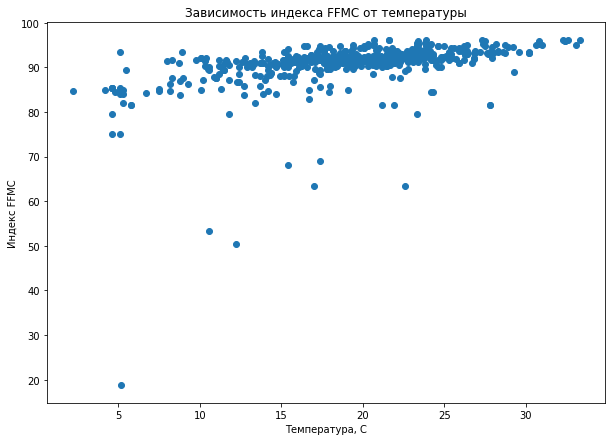

In [16]:
X = np.array(data.temp) # Объясняющая переменная
Y = np.array(data.FFMC) # Объясняемая переменная
plt.figure(figsize=(10,7))
plt.scatter(X,Y)
plt.title('Зависимость индекса FFMC от температуры')
plt.xlabel('Температура, С')
plt.ylabel('Индекс FFMC')
plt.show()

Из графика можно сделать выввод, что достаточно первой степени многочлена, т.е. $$Y_{i}=\theta_{0}+\theta_{1}X_{i}$$ 
Найдем МНК-оценку $$\hat{\theta}=(H^{T}H)^{-1}H^{T}Y$$
А далее вычислим $$\hat{Y}=H\hat{\theta}$$

In [17]:
m = 1
H = []
for x in X:
    row = [x**i for i in range(2)]
    H.append(row)    
H = np.array(H)
theta = np.dot(np.dot(np.linalg.inv(np.dot(H.T,H)),H.T),Y)
Y_hat = []
Y_hat.append(np.dot(H,theta))

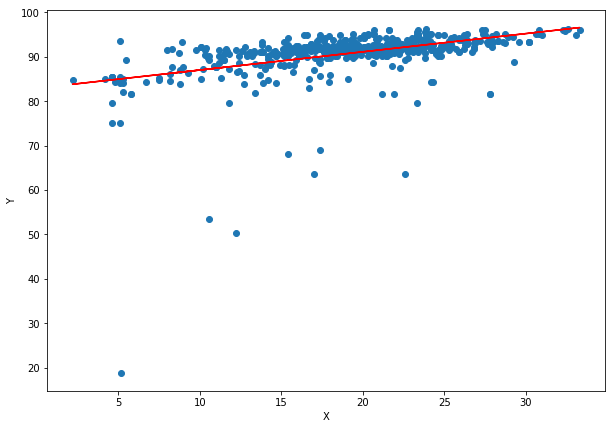

In [18]:
plt.figure(figsize = (10,7))
plt.scatter(X,Y)
for y in Y_hat:
    plt.plot(X,y, color = 'red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Вычислим остатки $$\hat{\varepsilon}=Y-\hat{Y}$$
и вспомогательные коэффициенты $$SS_{res}=\sum_{i=1}^{n}{\hat{\varepsilon}_{i}^{2}}$$ $$SS_{tot}=\sum_{i=1}^{n}(Y_{i}-\overline{Y})^{2}$$
Теперь можно вычислить коэффициент детерминации $$R^{2}=1-\frac{SS_{res}}{SS_{tot}}$$

In [19]:
e_hat = Y-Y_hat
SS_res = np.sum(e_hat**2)
SS_tot = np.sum((Y-Y.mean())**2)
R = 1 - SS_res/SS_tot
print(R)

0.18622009071180368


Проверим, имеют ли остатки нормальное распределение. Используем для этого тест Шапиро-Уилка

In [20]:
sh_test = shapiro(e_hat)
round(sh_test.pvalue, 3)

0.0

Значение P-value близко к нулю, значит, ошибки не имеют нормального распределения.

Построим М оценки по формуле $$\sum_{i=1}^{n}{\rho(Y_{i}-\sum_{j=0}^{m}{\theta_{j}X^{j}_{i}})}\rightarrow min$$
где в качестве функции $$\rho(u)$$ рассмотрим функцию Хьюбера
$$\begin{equation*}
\rho(u)= 
 \begin{cases}
   \frac{u^{2}}{2} &\text{, |u|}\leq\delta\\
   \delta(|u|-\frac{1}{2}\delta) &\text{, |u|}>\delta
 \end{cases}
\end{equation*}$$
и функцию Тьюки
$$\begin{equation*}
\rho(u)= 
 \begin{cases}
   \frac{\delta^{2}}{6}(1-(1-(\frac{u}{\delta})^{2})^{3}) &\text{, |u|}\leq\delta\\
   \frac{\delta^{2}}{6} &\text{, |u|}>\delta
 \end{cases}
\end{equation*}$$

In [46]:
delta = 0.1
Y_norm = (Y-Y.mean())/Y.std()
# Функция Хьюбера
def huber(u):
    if(abs(u) <= delta):
        return(u**2/2)
    else:
        return(delta*(abs(u) - delta/2))
# Функция Тьюки
def tukey(u):
    if(abs(u) <= delta):
        return((delta**2/6)(1-(1-(u/delta)**2)**3))
    else:
        return(delta**2/6)

def func_huber(theta):
    return np.sum([huber(y-np.sum(theta*h)) for y, h in zip(Y_norm,H)])

def func_tukey(theta):
    return np.sum([tukey(y-np.sum(theta*h)) for y, h in zip(Y_norm,H)])

In [60]:
theta_huber = fmin(func_huber, theta)
theta_tukey = fmin(func_tukey, theta)
Y_huber = np.dot(H,theta_huber)
Y_tukey = np.dot(H,0.003*theta_tukey)

Optimization terminated successfully.
         Current function value: 17.497681
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.861667
         Iterations: 17
         Function evaluations: 67


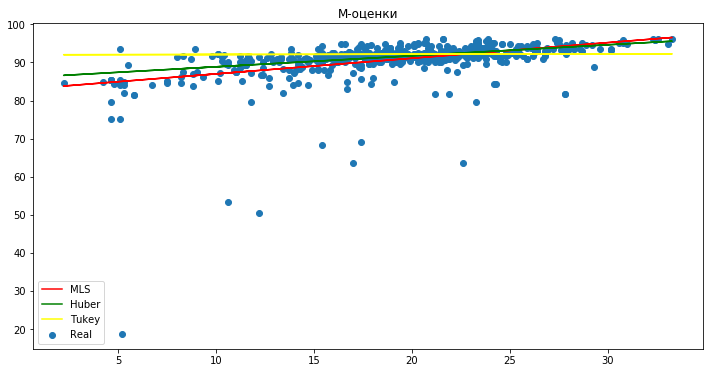

In [61]:
plt.figure(figsize=(12,6))
plt.scatter(X,Y, label='Real')
for y in Y_hat:
    plt.plot(X,y, color = 'red', label='MLS')
plt.plot(X,Y_huber*Y.std() + Y.mean(), color = 'green', label='Huber')
plt.plot(X,Y_tukey*Y.std() + Y.mean(), color = 'yellow', label='Tukey')
plt.title('М-оценки')
plt.legend()
plt.show()